In [1]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [2]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [4]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [5]:
from dotenv import load_dotenv
load_dotenv()
import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "ReAct-Agent"

In [6]:
def multiply(a:int,b:int) -> int:
    """Multiply  a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int
    """
    return a*b

def add(a:int,b:int) -> int:
    """ Adds a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: 
    """
    return a+b
    
def divide(a:int,b:int) -> float:
    """Divide a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        float:
    """
    return a/b

tools = [arxiv,wiki,multiply,divide]

In [7]:
from langchain_tavily import TavilySearch
tavily = TavilySearch()

In [8]:
tavily.invoke("Recent AI News on India")

{'query': 'Recent AI News on India',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Latest AI News, Updates and Launches - Analytics India Magazine',
   'url': 'https://analyticsindiamag.com/ai-news-updates/',
   'content': 'Get latest coverage in artificial intelligence, including news, trends, and insights across various sectors such as Generative AI, machine learning etc.',
   'score': 0.72395444,
   'raw_content': None},
  {'title': 'Latest AI Technology, Artificial Intelligence News and Updates',
   'url': 'https://www.livemint.com/ai',
   'content': 'Get the latest AI Technology News and updates. Explore mint to know more about AI news, AI applications & more in India and across the world.',
   'score': 0.68571854,
   'raw_content': None},
  {'title': 'Artificial Intelligence: Read latest news updates on AI technology',
   'url': 'https://indianexpress.com/section/technology/artificial-intelligence/',
   'content': 'Artificial Intelligence: 

In [9]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4.1")
llm_with_tools = llm.bind_tools(tools)

In [10]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"what is india's recent political news?")])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5CFCw5n8s9KjtSfCDtgPIV1X', 'function': {'arguments': '{"query":"Recent political news in India"}', 'name': 'wikipedia'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 221, 'total_tokens': 238, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_51e1070cf2', 'id': 'chatcmpl-BngIqqCGhSdJphMdDj6WM8R6Mb4WI', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--026602f6-9094-4d59-898a-126156085333-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Recent political news in India'}, 'id': 'call_5CFCw5n8s9KjtSfCDtgPIV1X', 'type': 'tool_call'}], usage_metadata={'input_tokens': 221, 'output_tokens': 17, 'tot

In [11]:
llm_with_tools.invoke([HumanMessage(content=f"what is india's recent political news?")]).tool_calls

[{'name': 'wikipedia',
  'args': {'query': 'India recent political news'},
  'id': 'call_GvvdIp2wjvVNseU8BDI81tHi',
  'type': 'tool_call'}]

In [12]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

In [13]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

## Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

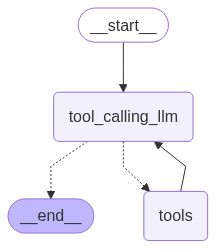

In [14]:
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))